# IMF 외환위기 트라우마 분석  - 개요

본 주피터 노트북에선 IMF 외환위기 당시 퇴직자이냐 아니냐가 추후의 소비 및 투자 성향에 어떠한 영향을 미치는지 알아본다.

실험은 아래와 같은 네 단계 절차로 진행 된다:
1. IMF 당시 정년이었던 사람, 그리고 정년이 아니었던 사람으로 그룹을 나눈다. 
2. 통제 변수 X와 추정값 Y를 찾는다. 
3. Linear Regression을 돌린다.
4. Causal Forest를 돌린다.

In [1]:
# Data Manipulation Libraries
import numpy as np
import pandas as pd
from scipy import stats
import pyreadstat

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing Libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

# Machine Learning Libraries
from xgboost import XGBRegressor, XGBClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score

# Econometrics Libraries
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
import statsmodels.api as sm
from scipy.stats import norm

# Explainability Libraries
import shap

# Model Storage Libraries
import joblib

# Optional: Uncomment if you need to install xgboost within the notebook
# !pip install xgboost

In [2]:
csv_file_path = '2020_survey_data_cleansed.csv'
df = pd.read_csv(csv_file_path)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# 1.  그룹 나누기
우리의 가설은 "IMF 당시 퇴직을 한 사람과 그 전에 퇴직한 사람이 소비 및 투자 습관에서 차이가 유의미한 차이가 있다는 것"이다. 이를 분석하기 위해서 IMF 당시 퇴직자와 비퇴직자 두 그룹으로 나눠야 한다.

**첫째로,**  노인실태조사에 퇴직 연령은 명시되지 않았기 때문에 확실히 집단을 나눌 수는 없다. 그래서 우리는 정년, 그리고 당시 정리해고/권고사직 평균연령을 기준으로 잡는다.

- IMF 외환위기 당시 국가가 지정한 정년은 만 60세이다 (지금도 동일).
- 한국 노동연구원에 따르면 IMF 외환위기 당시 정리해고/권고사직 평균연령은 약 50세이다. [기사](https://www.labortoday.co.kr/news/articleView.html?idxno=39838)

60세와 50세, 이 두가지 구분선을 취했다

**둘째로,** 어떻게 "IMF 당시 퇴직을 한 사람과 그 전에 퇴직한 사람" 이 두가지로 나눌 수 있는지 살펴본다.

대한민국의 관리체제 기간은 1997년 12월 3일부터 2001년 8월 23일까지 약 3년 8개월이었다. 고로 아래와 같은 세 집단으로 나눌 수 있다:

- 첫번째 집단은 97년 당시 (관리체제 시작) 40-49세였던 집단이다. 2001년 기준 43-52세, 2020년 기준 63-72세인 집단이다 (+23). <데이터는 65세 부터 시작>
- 두번째 집단은 97년 당시 (관리체제 종료) 50-59세였던 집단이다. 2001년 기준 53-62세, 2020년 기준 73-82세인 집단이다 (+23).
- 세번째 집단은 97년 당시 (관리체제 시작) 60-69세였던 집단이다. 2001년 기준 63-72세, 2020년 기준 83-92세인 집단이다 (+23).

데이터프레임 df에 칼럼 'treatment'를 추가한다. 넷 중 하나의 값을 가진다:
- forty: 40-49
- fifty: 50-59
- sixty: 60-69 
- rest: 그 외 데이터

In [4]:
conditions = [
    (df['RES_AGE'] >= 63) & (df['RES_AGE'] <= 72),
    (df['RES_AGE'] >= 73) & (df['RES_AGE'] <= 82),
    (df['RES_AGE'] >= 83) & (df['RES_AGE'] <= 92)
]
values = ["forty", "fifty", "sixty"]
df['treatment'] = np.select(conditions, values, default="rest")
df = df[df['treatment'] != "rest"]

df['leisure_expense_ratio'] = df['J1b_3']/ df['J4']

# 2. 통제 변수 X와 Y 찾기

일단 X를 살펴본다.
- 건강: B1 (1->5 안 좋아짐)*(비해당:9)*
- 성별: RES_SEX <남자: 1, 여자: 2> -> categorical
- 교육수준: RES_EDU1 <1->7 높아짐>
-  지역 (광역시/도): AREA -> categortical
    - <11:서울 21:부산 22:대구 23:인천 24:광주 25:대전 26:울산 29:세종 31:경기 32:강원 33:충북 34:충남 35:전북 36:전남 37:경북 38:경남 39:제주>
- 지역: EDM 동부/읍면부 (1:동부 0:읍면부)
- 본인 총수입액 금액: J3b_1_13 
- 나이: RES_AGE
- 인지기능: I1x1 *(결측치:99)*

그 다음 Y를 살펴본다
- 부동산자산비중: property_equity_ratio
- 금융자산비중: financial_equity_ratio
- 문화여가비비중: leisure_expense_ratio (월평균 여가비 소비/월평균 소비지출액)
- 우울증척도총점: B6_SUM
- 만족도_경제상태: H16_2 (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)
- 만족도_삶 전반: H16_7  (1:매우 만족함 2:만족함 3:그저 그렇다 4:만족하지 않음 5:전혀 만족하지 않음)

In [5]:
AREAs = [11,21,22,23,24,25,26,29,31,32,33,34,35,36,37,38,39]
# 지역 값 바꿔주기
df['AREA'] = df['AREA'].replace({11:"Seoul", 21:"Busan", 22:"Daegu", 23:"Incheon", 24:"Gwangju", 25:"Daejeon", 
         26:"Ulsan", 29:"Sejong", 31:"Gyeonggi", 32:"Gangwon",
        33:"Chungbuk", 34:"Chungnam",35:"Jeonbuk",36:"Jeonnam",
        37:"Gyeongbuk",38:"Gyeongnam", 39:"Jeju"})

In [6]:
# Treatment 에 대한 one-hot encoding
treatment_dummies = pd.get_dummies(df['treatment'], prefix='treatment')
treatment_dummies = treatment_dummies.drop(columns=['treatment_sixty'])

# AREA에 대한 one-hot encoding
AREA_dummies = pd.get_dummies(df['AREA'], prefix='AREA')
AREA_dummies = AREA_dummies.drop(columns=['AREA_Seoul']) 

# Concatenate
treatment_columns = treatment_dummies.columns.tolist()
area_columns = AREA_dummies.columns.tolist()
df = pd.concat([df, treatment_dummies, AREA_dummies], axis=1)


X_columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + treatment_columns + area_columns
Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

X = df[X_columns]
X = sm.add_constant(X)

In [7]:
# # Treatment에 대한 one-hot encoding
# treatment_dummies = pd.get_dummies(df['treatment'], prefix='treatment')
# treatment_dummies = treatment_dummies.drop(columns=['treatment_sixty'])

# # AREA에 대한 one-hot encoding
# AREA_dummies = pd.get_dummies(df['AREA'], prefix='AREA')
# AREA_dummies = AREA_dummies.drop(columns=['AREA_Seoul']) 

# # Concatenate
# treatment_columns = treatment_dummies.columns.tolist()
# area_columns = AREA_dummies.columns.tolist()
# df = pd.concat([df, treatment_dummies, AREA_dummies], axis=1)

# X_columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + treatment_columns + area_columns
# Y_options = ['property_equity_ratio','leisure_expense_ratio','B6_SUM','H16_2','H16_7']

# # Extract the specified columns
# columns = ['B1','RES_SEX','RES_EDU1','EDM','J3b_1_13','RES_AGE','I1x1'] + Y_options
# columns_to_standardize = df[columns]

# # Initialize the standard scaler
# scaler = StandardScaler()

# # Standardize the specified columns
# standardized_columns = scaler.fit_transform(columns_to_standardize)

# # Replace the original columns with the standardized values
# df[columns] = standardized_columns
# X = df[X_columns]
# X = sm.add_constant(X)


# 3. Linear Regression

## 3.1 부동산 자산 비중

property_equity_ratio
                              OLS Regression Results                             
Dep. Variable:     property_equity_ratio   R-squared:                       0.057
Model:                               OLS   Adj. R-squared:                  0.054
Method:                    Least Squares   F-statistic:                     23.19
Date:                   Mon, 14 Aug 2023   Prob (F-statistic):          4.68e-103
Time:                           20:10:22   Log-Likelihood:                 1224.0
No. Observations:                   9629   AIC:                            -2396.
Df Residuals:                       9603   BIC:                            -2210.
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

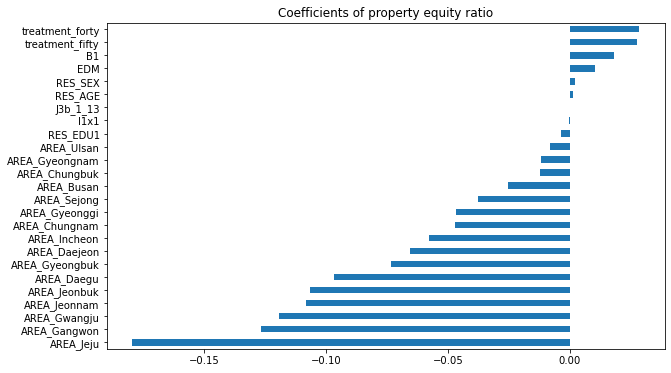

In [8]:
model = sm.OLS(df['property_equity_ratio'], X).fit()
               
print("property_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of property equity ratio")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.1)

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|-------------------|
| treatment_forty | 0.092  | 1                  | + 0.0286    | IMF당시 근로자의 부동산자산비중 더 높음  |
| treatment_fifty | 0.009  | 3                  | + 0.0277    | IMF당시 근로자의 부동산자산비중 더 높음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                   | + 0.0181   | 건강이 안 좋을수록 부동산자산비중 높음 |
| EDM             | 0.092  | 1                  |  + 0.0104   | 동에 있을수록 부동산자산비중 더 높음 |
| J3b_1_13        |  0.000 | 3                  | - 5.454e-06   | 소득이 높을수록 부동산자산비중 더 낮음 |
| AREA            |  대체로 낮음 | 대체로 높음         |  마이너스 값   | 非서울이 부동산자산비중 더 낮음 |
|- |- |- |- |- |
| RES_SEX         | 0.640  | 0                  |  + 0.0022  |남성의 부동산자산비중 높음|
| RES_EDU1        | 0.131  | 0                  |  - 0.0034  | 교육수준 높을수록 부동산자산비중 더 낮음 |
| I1x1            |  0.699 | 0                  |  - 0.0002   | 인지기능이 높을수록 부동산자산비중 더 낮음 |
| RES_AGE         |  0.208 | 0                  |  - 0.0011   | 나이가 많을수록 부동산자산비중 더 낮음 |






- EDM과 AREA를 보았을때 부동산자산비중의 경우 거주지역이 미치는 영향이 매우 큰 듯 하다. 하지만 coefficient와 [집값](http://buking.kr/r/ms) 순위와는 완벽히 매핑 되지는 않는 것 같다. 
- B1(건강)과 J3b_1_13(소득)을 보았을 때, 건강하고 부유할수록 부동산자산비중이 낮은 것으로 보인다.
- treatment_forty와 treatment_fifty의 coefficient가 유의미하게 낮은 p-value를 보인다. 



## 3.2 금융자산비중

financial_equity_ratio
                              OLS Regression Results                              
Dep. Variable:     financial_equity_ratio   R-squared:                       0.044
Model:                                OLS   Adj. R-squared:                  0.041
Method:                     Least Squares   F-statistic:                     17.63
Date:                    Mon, 14 Aug 2023   Prob (F-statistic):           1.11e-75
Time:                            20:10:22   Log-Likelihood:                 2268.2
No. Observations:                    9629   AIC:                            -4484.
Df Residuals:                        9603   BIC:                            -4298.
Df Model:                              25                                         
Covariance Type:                nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

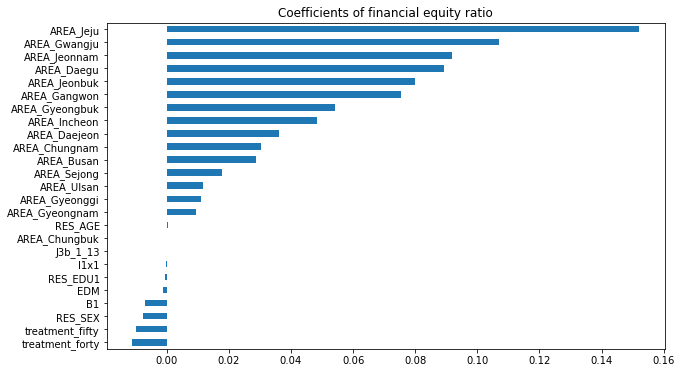

In [9]:
model = sm.OLS(df['financial_equity_ratio'], X).fit()
               
print("financial_equity_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of financial equity ratio")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.05)

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.462  | 0                  | - 0.0112      | IMF당시 근로자의 금융자산비중 더 낮음  |
| treatment_fifty | 0.296  | 0                  | - 0.0100      | IMF당시 근로자의 금융자산비중 더 낮음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.005  | 1                  |  - 0.0069      | 건강이 안 좋을수록 금융자산비중 낮음 |
| RES_SEX         | 0.072  | 1                  | - 0.0077      | 남성의 금융자산비중 더 낮음 |
| AREA            |  대체로 낮음 | 대체로 높음        |  플러스 값      | 非서울이 금융자산비중 더 높음 |
|- |- |- |- |- |
| RES_EDU1        | 0.790  | 0                  | - 0.0005      | 교육수준 높을수록 금융자산비중 더 낮음 |
| EDM             | 0.830  | 0                  | - 0.0012      | 동에 있을수록 금융자산비중 더 낮음 |
| J3b_1_13        |  0.482 | 0                  |  - 6.122e-07  | 소득이 높을수록 금융자산비중 더 낮음 |
| RES_AGE         |  0.737 | 0                  | + 0.0003      | 나이가 많을수록 금융자산비중 더 높음 |
| I1x1            |  0.752 | 0                  | - 0.0001      | 인지기능이 높을수록 금융자산비중 더 낮음 |

- 금융자산이 부동산자산의 역수라고 단순히 생각했으나, 금융자산비중으로 회귀를 돌리니 coefficients의 p값이 전체적으로 줄어듦.
- treatment_40과 treatment_50의 p값이 다소 높음


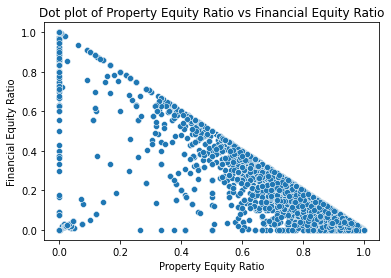

The correlation between Property Equity Ratio and Financial Equity Ratio is -0.9028677489235706


In [10]:
sns.scatterplot(x='property_equity_ratio', y='financial_equity_ratio', data=df)
plt.title('Dot plot of Property Equity Ratio vs Financial Equity Ratio')
plt.xlabel('Property Equity Ratio')
plt.ylabel('Financial Equity Ratio')
plt.show()
correlation = df['property_equity_ratio'].corr(df['financial_equity_ratio'])
print(f"The correlation between Property Equity Ratio and Financial Equity Ratio is {correlation}")

## 3.3 문화여가비 지출 비중

leisure_expense_ratio
                              OLS Regression Results                             
Dep. Variable:     leisure_expense_ratio   R-squared:                       0.158
Model:                               OLS   Adj. R-squared:                  0.156
Method:                    Least Squares   F-statistic:                     72.15
Date:                   Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                           20:10:23   Log-Likelihood:                 12023.
No. Observations:                   9629   AIC:                        -2.399e+04
Df Residuals:                       9603   BIC:                        -2.381e+04
Df Model:                             25                                         
Covariance Type:               nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

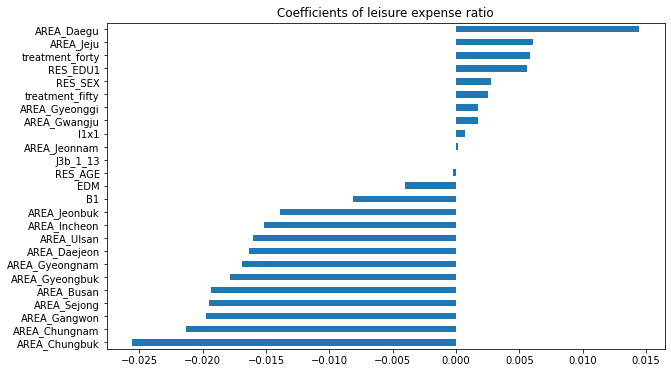

In [11]:
model = sm.OLS(df['leisure_expense_ratio'], X).fit()
               
print("leisure_expense_ratio")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of leisure expense ratio")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.05)

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.292  | 0                  | + 0.0058      | IMF당시 근로자의 문화여가비비중 더 높음  |
| treatment_fifty | 0.466  | 0                  | + 0.0025      | IMF당시 근로자의 문화여가비비중 더 높음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                  | - 0.0081      | 건강이 안 좋을수록 문화여가비비중 더 낮음 |
| RES_SEX         | 0.075  | 1                  | + 0.0028      | 남성의 문화여가비비중 더 높음 |
| RES_EDU1        | 0.000  | 3                  | + 0.0056      | 교육수준 높을수록 문화여가비비중 더 높음 |
| EDM             | 0.044  | 2                  | - 0.0040      | 동에 있을수록 문화여가비비중 더 낮음 |
| J3b_1_13        | 0.000  | 3                  | + 7.414e-06   | 소득이 높을수록 문화여가비비중 더 낮음 |
| I1x1            | 0.000  | 3                  | + 0.0007      | 인지기능이 높을수록 문화여가비비중 더 높음 |
| AREA            |대체로 낮음|  대체로 높음          |   -          |  -                             |
|- |- |- |- |- | 
| RES_AGE         | 0.389  | 0                  | - 0.0003      | 나이가 많을수록 문화여가비비중이 더 낮음  |

- treatment_forty와 treatment_fifty의 p값이 높다. 
- AREA: 대구와 제주가 유독 높으며, 나머지는 서울보다 아래.

## 3.4. 우울의 정도

Depression Score
                            OLS Regression Results                            
Dep. Variable:                 B6_SUM   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     114.6
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:10:23   Log-Likelihood:                -22608.
No. Observations:                9629   AIC:                         4.527e+04
Df Residuals:                    9603   BIC:                         4.545e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.602

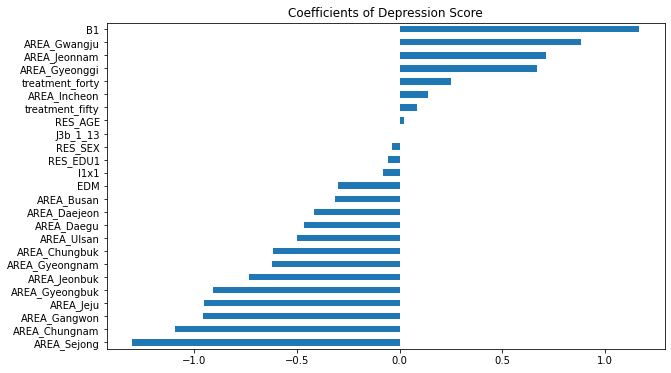

In [12]:
model = sm.OLS(df['B6_SUM'], X).fit()
               
print("Depression Score")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Coefficients of Depression Score")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.05)

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.216  | 0                  | + 0.2487      | IMF당시 근로자의 우울증수치가 더 높음  |
| treatment_fifty | 0.501  | 0                  | + 0.0854      | IMF당시 근로자의 우울증수치가 더 높음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                  | + 1.1696      | 건강이 안 좋을수록 우울증수치 더 높음 |
| RES_EDU1        | 0.039  | 2                  | - 0.0553      | 교육수준 높을수록 우울증수치 더 낮음 |
| EDM             | 0.000  | 3                  | - 0.2999      | 동에 있을수록 우울증수치 더 낮음 |
| J3b_1_13        | 0.001  | 2                  | - 3.779e-05   | 소득이 높을수록 우울증수치 더 낮음 |
| RES_AGE         | 0.068  | 1                  | + 0.0196      | 나이가 많을수록 우울증수치가 더 높음  |
| I1x1            | 0.000  | 3                  | - 0.0825      | 인지기능이 높을수록 우울증수치 더 낮음 |
| AREA            |대체로 낮음|  대체로 높음         |   -           |  -                             |
|- |- |- |- |- | 
| RES_SEX         | 0.542  | 1                  | - 0.0347      | 남성의 우울증수치가 더 낮음 |

- treatment의 p값은 높다.
- **treatment의 coefficient는 양수인데 RES_AGE의 coefficient도 양수이다.** 나이가 많을수록 우울증수치는 더 높아야 하나, 되려 40,50의 젊은 집단의 우울증수치가 더 높다고 나오는 것이다. 우리의 가설을 보다 뒷받침하는 근거가 되지 않을까 싶다. 

## 3.5. 경제상태 불만족도

Financial Discontent
                            OLS Regression Results                            
Dep. Variable:                  H16_2   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.236
Method:                 Least Squares   F-statistic:                     120.0
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:10:24   Log-Likelihood:                -11233.
No. Observations:                9629   AIC:                         2.252e+04
Df Residuals:                    9603   BIC:                         2.270e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2

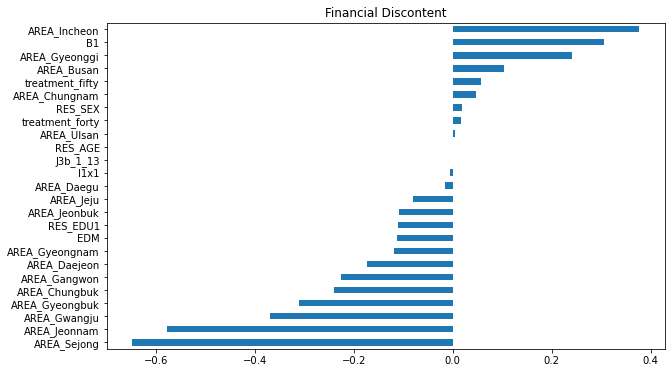

In [13]:
model = sm.OLS(df['H16_2'], X).fit()
               
print("Financial Discontent")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Financial Discontent")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.05)

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.798  | 0                  | + 0.0158      | IMF당시 근로자의 경제적 불만족도가 더 높음  |
| treatment_fifty | 0.144  | 0                  | + 0.0568      | IMF당시 근로자의 경제적 불만족도가 더 높음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                  | + 0.3057      | 건강이 안 좋을수록 경제적불만족도가 더 높음   |
| RES_EDU1        | 0.000  | 3                  | - 0.1096      | 교육수준 높을수록 경제적불만족도가 더 낮음 |
| EDM             | 0.000  | 3                  | - 0.1132      | 동에 있을수록 경제적불만족도가 더 낮음      |
| J3b_1_13        | 0.000  | 3                  | - 3.381e-05   | 소득이 높을수록 경제적불만족도가 더 낮음     |
| I1x1            | 0.007  | 3                  | - 0.0047      | 인지기능이 높을수록 경제적불만족도가 더 낮음  |
| AREA            |대체로 낮음|  대체로 높음         |   -           |  -                             |
|- |- |- |- |- | 
| RES_SEX         | 0.308  | 1                  | + 0.0178      | 남성의 경제적불만족도가 더 높음       |
| RES_AGE         | 0.787  | 1                  | + 0.0009      | 나이가 많을수록 경제적불만족도가 더 높음 |

- treatment의 p값은 높다.
- AREA: 인천 경기 부산이 경제적불만족도가 가장 높으며 세종이 가장 낮다. 
-  **나이가 많을수록 경제적불만족도가 높은 것에 반해 IMF 당시 근로자의 경제적 불만족도가 더 높은 것을 볼 수 있다.** 비록 treatment와 RES_AGE의 p값이 다소 높지만, 우리의 가설을 뒷받침하는 근거가 될지도 모른다. 

## 3.6. 삶 불만족도

Life Discontent
                            OLS Regression Results                            
Dep. Variable:                  H16_7   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     108.5
Date:                Mon, 14 Aug 2023   Prob (F-statistic):               0.00
Time:                        20:10:24   Log-Likelihood:                -8988.3
No. Observations:                9629   AIC:                         1.803e+04
Df Residuals:                    9603   BIC:                         1.822e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               2.7387

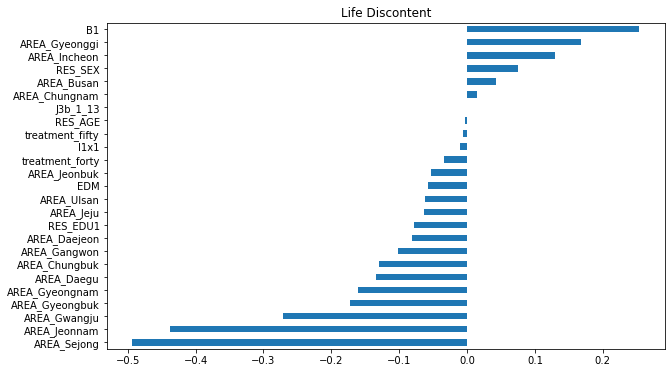

In [14]:
model = sm.OLS(df['H16_7'], X).fit()
               
print("Life Discontent")
print(model.summary()) 
               
plt.figure(figsize=(10, 6))
coefficients = model.params.drop('const')
coefficients.sort_values().plot(kind='barh')
plt.title("Life Discontent")
plt.show()

- 3 : Highly significant (p < 0.01)
- 2 : Significant (0.01 ≤ p < 0.05)
- 1 : Significant (0.05 ≤ p < 0.1)
- 0 : Not significant (p ≥ 0.05)

| column name    | P-value | significance level | coefficient | explanation|
|----------------|---------|-------------|-----------------|---------------|
| treatment_forty | 0.495  | 0                  | - 0.0334      | IMF당시 근로자의 삶의 불만족도가 더 낮음 |
| treatment_fifty | 0.844  | 0                  | - 0.0061      | IMF당시 근로자의 삶의 불만족도가 더 낮음  |
|- |- |- |- |- |
| B1(건강나쁜정도)   | 0.000  | 3                  | + 0.2538      | 건강이 안 좋을수록 삶의 불만족도가 더 높음 |
| RES_SEX         | 0.000  | 3                  | + 0.0749      | 남성의 삶의 불만족도가 더 높음 |
| RES_EDU1        | 0.000  | 3                  | - 0.0789      | 교육수준 높을수록 삶의 불만족도가 더 낮음 |
| EDM             | 0.001  | 3                  | - 0.0577      | 동에 있을수록 삶의 불만족도가 더 낮음 |
| J3b_1_13        | 0.000  | 3                  | - 1.783e-05   | 소득이 높을수록 삶의 불만족도가 더 낮음 |
| I1x1            | 0.000  | 3                  | - 0.0110      | 인지기능이 높을수록 삶의 불만족도가 더 낮음 |
| AREA            |대체로 낮음|  대체로 높음         |   -           |  -                             |
|- |- |- |- |- | 
| RES_AGE         | 0.278  | 0                  | - 0.0028      | 나이가 많을수록 삶의 불만족도가 더 낮음  |


- treatment의 p값은 높다.
- **treatment의 coefficient는 음수인데 RES_AGE의 coefficient도 음수이다.** 나이가 많을수록 삶의 불만족도는 더 낮으나, 되려 40,50의 젊은 집단의 삶의 불만족도도 낮다고 나오는 것이다. "IMF를 견딘 세대가 더 감사할 줄 안다" 등으로 해석이 가능할런지 모르겠다.
- 경제적 불만족도와 삶의 불만족도가 같이 가지 않는 경우가 있다:
    - 남성의 경제적 불만족도가 더 높으나 삶의 불만족도는 더 낮다.
    - 동에 있으면 경제적불만족도가 더 낮으나 삶의 불만족도는 더 높다. 